<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/09_pytorch_model_deployment_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09. PyTorch Model Deployment Exercises

Welcome to the 09. PyTorch Model Deployment exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/jOX5ZCkWO-0) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/). 

In [2]:
# # For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
# try:
#     import torch
#     import torchvision
#     assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) > 1, "torch version should be 1.12+"
#     assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
#     print(f"torch version: {torch.__version__}")
#     print(f"torchvision version: {torchvision.__version__}")
# except:
#     print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
#     !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
#     import torch
#     import torchvision
#     print(f"torch version: {torch.__version__}")
#     print(f"torchvision version: {torchvision.__version__}")


In [3]:
from helper_functions import accuracy_fn, download_data, plot_decision_boundary, plot_loss_curves, plot_predictions, set_seeds
# from helper_functions import download_data, set_seeds, plot_loss_curves
from going_modular import engine, data_loaders
from going_modular import predictions
from going_modular.engine import train_step, test_step
from going_modular.utils import save_model
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
import os
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import random
import shutil
import requests
import sklearn
from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from torchinfo import summary
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torchmetrics import Accuracy, ConfusionMatrix
import torchvision
from torchvision import datasets

from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import Tuple, Dict, List
writer = SummaryWriter()
import zipfile



In [4]:
# # Continue with regular imports
# import matplotlib.pyplot as plt
# import torch
# import torchvision

# from torch import nn
# from torchvision import transforms

# # Try to get torchinfo, install it if it doesn't work
# try:
#     from torchinfo import summary
# except:
#     print("[INFO] Couldn't find torchinfo... installing it.")
#     !pip install -q torchinfo
#     from torchinfo import summary

# # Try to import the going_modular directory, download it from GitHub if it doesn't work
# try:
#     from going_modular.going_modular import data_setup, engine
#     from helper_functions import download_data, set_seeds, plot_loss_curves
# except:
#     # Get the going_modular scripts
#     print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
#     !git clone https://github.com/mrdbourke/pytorch-deep-learning
#     !mv pytorch-deep-learning/going_modular .
#     !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
#     !rm -rf pytorch-deep-learning
#     from going_modular.going_modular import data_setup, engine
#     from helper_functions import download_data, set_seeds, plot_loss_curves

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Model Deployment: https://www.learnpytorch.io/09_pytorch_model_deployment/#1-getting-data

In [6]:
# # Download pizza, steak, sushi images from GitHub
# image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
#                            destination="pizza_steak_sushi")
# image_path

In [7]:
# Setup directory paths to train and test images
image_path = Path('../data/pizza_steak_sushi_20_percent')
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [8]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [9]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
# train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
train_dataloader, test_dataloader, class_names = data_loaders.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1423a640ee0>,
 ['pizza', 'steak', 'sushi'])

In [10]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

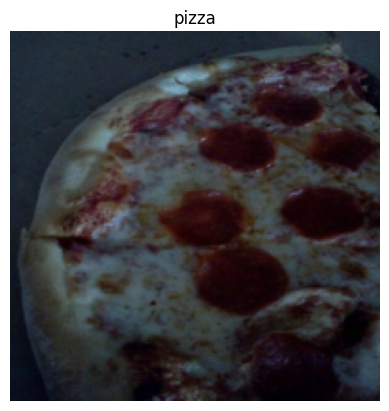

In [11]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## Exercise 1. Make and time predictions with both feature extractor models on the test dataset using the GPU (`device="cuda"`). 

* Compare the model's prediction times on GPU vs CPU - does this close the gap between them? As in, does making predictions on the GPU make the ViT feature extractor prediction times closer to the EffNetB2 feature extractor prediction times?
* You'll find code to do these steps in [section 5. Making predictions with our trained models and timing them](https://www.learnpytorch.io/09_pytorch_model_deployment/#5-making-predictions-with-our-trained-models-and-timing-them) and [section 6. Comparing model results, prediction times and size](https://www.learnpytorch.io/09_pytorch_model_deployment/#6-comparing-model-results-prediction-times-and-size).

In [12]:
# TODO: your code

In [13]:
# function to create effnetb2
def create_effnetb2(output_feature_count:int, drop_out = 0.3, seed:int=42,
                    device:str ='cuda')-> nn.Module:
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms= weights.transforms()
    # model = torchvision.models.efficientnet_b2(weights="DEFAULT").to(device)
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    for param in model.features.parameters():
        param.requires_grad = False

    set_seeds()

    last_layer = list(model.children())[-1]
    last_child_layer = list(last_layer.children())[-1]
    last_input = last_child_layer.in_features

    model.classifier = nn.Sequential(
        nn.Dropout(p = drop_out, inplace=True),
        nn.Linear(in_features =last_input, 
                  out_features = output_feature_count).to(device))

    model.name = 'effnetb2'
    print (f'[INFO] created new {model.name} model')
    
    return model, transforms




In [14]:
effnetb2, effnetb2_transforms = create_effnetb2(output_feature_count=3)
effnetb2
print(summary(model=effnetb2,
        input_size= (1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names']))

effnetb2_transforms

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to C:\Users\Hassan/.cache\torch\hub\checkpoints\efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:04<00:00, 8.51MB/s]


[INFO] created new effnetb2 model
Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [15]:
loss_fn = nn.CrossEntropyLoss()
effnetb2_optimizer = torch.optim.Adam(effnetb2.parameters(), lr=1e-3)

In [16]:
# general trainer

def train (model: torch.nn.Module,
           train_dataloader: torch.utils.data.DataLoader,
           test_dataloader: torch.utils.data.DataLoader,
           optimizer: torch.optim.Optimizer,
           loss_fn: torch.nn.Module,
           epochs: int,
           device: torch.device,
           writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:
    
    results = {'train_loss':[],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model,
                                           dataloader = train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer=optimizer,
                                           device = device)
        
        test_loss, test_acc = test_step(model = model,
                                        dataloader = test_dataloader,
                                        loss_fn = loss_fn,
                                        device=device)
        
        print (
            f'Epoch: {epoch + 1} |'
            f'train_loss: {train_loss:.4f} |'
            f'train_acc: {train_acc:.4f} |'
            f'test_loss {test_loss:.4f} |'
            f'test_acc:  {test_acc}:.4f'

        )

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    if writer:
        writer.add_scalars (main_tag = 'Accuracy',
                            tag_scalar_dict = {'train_acc': train_acc,
                                              'test_acc':test_acc},
                            global_step=epoch)
        writer.add_scalars (main_tag = 'Loss',
                           tag_scalar_dict = {'train_loss': train_loss,
                                              'test_loss' : test_loss},
                            global_step = epoch)
        
        writer.add_graph (model = model,
                          input_to_model = torch.randn(32, 3, 224, 224).to(device))# 3 or 1?
    
    writer.close()

    return results

In [17]:
# train effnetb2
set_seeds()
device = 'cuda'
effnetb2_retults = train (model = effnetb2,
                          train_dataloader=train_dataloader,
                          test_dataloader=test_dataloader,
                          optimizer=effnetb2_optimizer,
                          loss_fn = loss_fn,
                          epochs = 10,
                          device=device,
                          writer=writer)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 0.9970 |train_acc: 0.5312 |test_loss 0.8100 |test_acc:  0.8852272727272726:.4f
Epoch: 2 |train_loss: 0.7347 |train_acc: 0.8250 |test_loss 0.6345 |test_acc:  0.9102272727272727:.4f
Epoch: 3 |train_loss: 0.5922 |train_acc: 0.8688 |test_loss 0.5463 |test_acc:  0.9130681818181818:.4f
Epoch: 4 |train_loss: 0.4711 |train_acc: 0.9125 |test_loss 0.4908 |test_acc:  0.890909090909091:.4f
Epoch: 5 |train_loss: 0.4528 |train_acc: 0.8667 |test_loss 0.4489 |test_acc:  0.8852272727272726:.4f
Epoch: 6 |train_loss: 0.4248 |train_acc: 0.8625 |test_loss 0.4183 |test_acc:  0.909659090909091:.4f
Epoch: 7 |train_loss: 0.4411 |train_acc: 0.8417 |test_loss 0.3873 |test_acc:  0.903409090909091:.4f
Epoch: 8 |train_loss: 0.4266 |train_acc: 0.8438 |test_loss 0.4045 |test_acc:  0.8761363636363637:.4f
Epoch: 9 |train_loss: 0.3690 |train_acc: 0.8750 |test_loss 0.3763 |test_acc:  0.8698863636363636:.4f
Epoch: 10 |train_loss: 0.3765 |train_acc: 0.8604 |test_loss 0.3371 |test_acc:  0.9193181818181

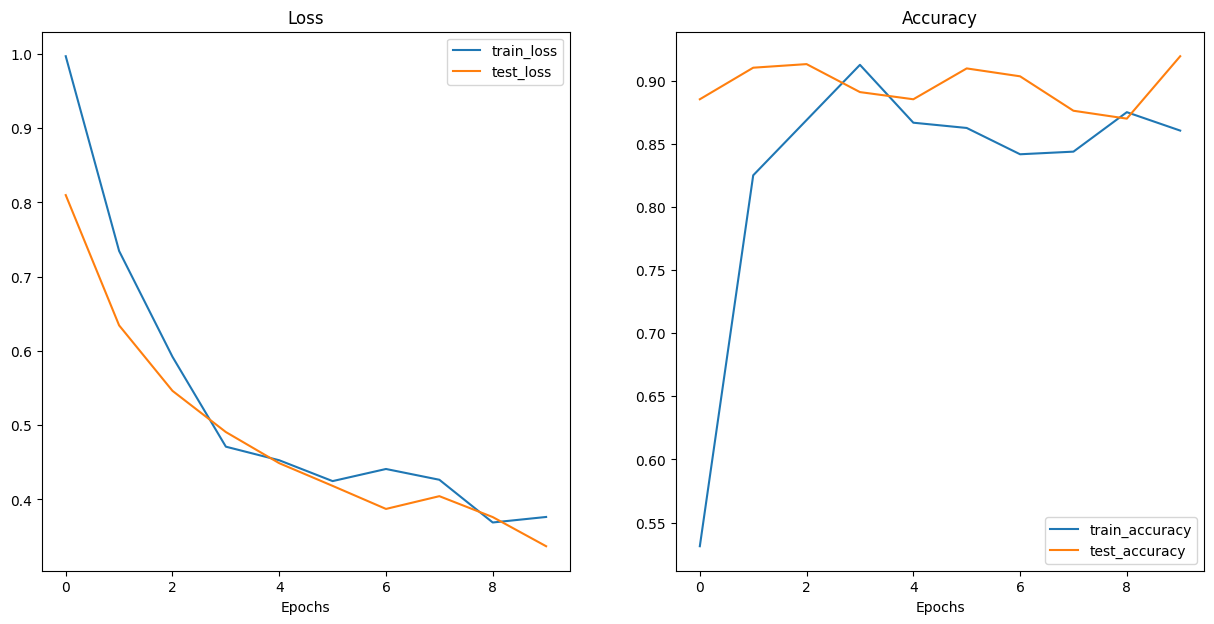

In [18]:
plot_loss_curves(effnetb2_retults)

In [19]:
model_path = f"09_pre_trained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent_{10}_epochs_exerciese.pth"
save_model (model = effnetb2,
            target_dir="models",
            model_name = model_path)

[INFO] Saving model to: models\09_pre_trained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent_10_epochs_exerciese.pth


In [20]:
pretrained_effnetb2_model_size = Path("models/", model_path).stat().st_size/(1024 * 1024)
# count number of paramters
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [21]:
effnetb2_stats = {'test_loss':effnetb2_retults['test_loss'][-1],
                  'test_acc':effnetb2_retults['test_acc'][-1],
                  'number_of_paramters': effnetb2_total_params,
                  'model_size (MB)': pretrained_effnetb2_model_size}

effnetb2_stats

{'test_loss': 0.3370713174343109,
 'test_acc': 0.9193181818181818,
 'number_of_paramters': 7705221,
 'model_size (MB)': 29.89727210998535}

In [22]:
def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in tqdm(test_paths):
    # Create empty dict to store info for each sample
    pred_dict = {}

    # Get sample path
    pred_dict["image_path"] = path

    # Get class name
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    #520cc050-f648-4d4d-b7ae-16850d1a8fbd Get prediction and prediction probability
    from PIL import Image
    
    # 6. timer
    start_time = timer()

    img = Image.open(path) # open image
    transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
    model.eval()
    with torch.inference_mode():
      # need to fix this. 
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      # pred_class = class_names[pred_label.cpu()]
      pred_class = class_names[pred_label.cpu()]

      # Make sure things in the dictionary are back on the CPU 
      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
      pred_dict["pred_class"] = pred_class

      # 12. End timerer
      end_time = timer()
      pred_dict["time_for_pred"] = round (end_time - start_time, 4)
  
    # Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # print(pred_dict)
    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)

  return test_pred_list

# test_pred_dicts = pred_and_store(test_paths=test_data_paths,
#                                  model=pretrained_vit_swag,
#                                  transform=vit_transforms_swag,
#                                  class_names=class_names,
#                                  device=device)

# test_pred_dicts = pred_and_store(test_paths=test_data_paths,
#                                  model=pretrained_vit_swag,
#                                  transform=vit_transforms_swag,
#                                  class_names=class_names,
#                                  device=device)

# test_pred_dicts[:5]

In [23]:
# test  data
device = 'cuda'
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                 model=effnetb2,
                                 transform=manual_transforms,
                                 class_names=class_names,
                                 device=device)
test_pred_dicts[:5]

  0%|          | 0/150 [00:00<?, ?it/s]

[{'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9850262999534607,
  'pred_class': 'pizza',
  'time_for_pred': 0.1901,
  'correct': True},
 {'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.36609888076782227,
  'pred_class': 'sushi',
  'time_for_pred': 0.1562,
  'correct': False},
 {'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9928351044654846,
  'pred_class': 'pizza',
  'time_for_pred': 0.2261,
  'correct': True},
 {'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.7557743787765503,
  'pred_class': 'pizza',
  'time_for_pred': 0.2175,
  'correct': True},
 {'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg'),
  'class_na

In [24]:
# test  data
device = 'cpu'
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                 model=effnetb2.to(device),
                                 transform=manual_transforms,
                                 class_names=class_names,
                                 device=device)
test_pred_dicts[:5]

  0%|          | 0/150 [00:00<?, ?it/s]

[{'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9850261807441711,
  'pred_class': 'pizza',
  'time_for_pred': 0.7066,
  'correct': True},
 {'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.36609917879104614,
  'pred_class': 'sushi',
  'time_for_pred': 0.6057,
  'correct': False},
 {'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9928351044654846,
  'pred_class': 'pizza',
  'time_for_pred': 0.3944,
  'correct': True},
 {'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.755774974822998,
  'pred_class': 'pizza',
  'time_for_pred': 0.5743,
  'correct': True},
 {'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg'),
  'class_nam

### Try with cpu

In [25]:
# import torch
# from your_model_file import YourModel  # Import your model class

# Initialize model architecture
model_cpu = effnetb2()

# Load the weights, ensuring they are mapped to CPU
model_cpu.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# # Set the model to evaluation mode
# model_cpu.eval()


TypeError: forward() missing 1 required positional argument: 'x'

## Exercise 2. The ViT feature extractor seems to have more learning capacity (due to more parameters) than EffNetB2, how does it go on the larger 20% split of the entire Food101 dataset?

* Train a ViT feature extractor on the 20% Food101 dataset for 5 epochs, just like we did with EffNetB2 in section [10. Creating FoodVision Big](https://www.learnpytorch.io/09_pytorch_model_deployment/#10-creating-foodvision-big).

In [11]:
# TODO: your code

In [28]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        self.patch_size = patch_size
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [26]:
class ViT(nn.Module): 
  def __init__(self,
               img_size=224, # from Table 3
               num_channels=3,
               patch_size=16,
               embedding_dim=768, # from Table 1
               dropout=0.1, 
               mlp_size=3072, # from Table 1
               num_transformer_layers=12, # from Table 1
               num_heads=12, # from Table 1 (number of multi-head self attention heads)
               num_classes=1000): # generic number of classes (this can be adjusted)
    super().__init__()

    # Assert image size is divisible by patch size 
    assert img_size % patch_size == 0, "Image size must be divisble by patch size."

    # 1. Create patch embedding
    self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # 2. Create class token
    self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                    requires_grad=True)

    # 3. Create positional embedding
    num_patches = (img_size * img_size) // patch_size**2 # N = HW/P^2
    self.positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))

    # 4. Create patch + position embedding dropout 
    self.embedding_dropout = nn.Dropout(p=dropout)

    # # 5. Create Transformer Encoder layer (single)
    # self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
    #                                                             nhead=num_heads,
    #                                                             dim_feedforward=mlp_size,
    #                                                             activation="gelu",
    #                                                             batch_first=True,
    #                                                             norm_first=True)

    # 5. Create stack Transformer Encoder layers (stacked single layers)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                              nhead=num_heads,
                                                                                              dim_feedforward=mlp_size,
                                                                                              activation="gelu",
                                                                                              batch_first=True,
                                                                                              norm_first=True), # Create a single Transformer Encoder Layer
                                                     num_layers=num_transformer_layers) # Stack it N times

    # 7. Create MLP head
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Get some dimensions from x
    batch_size = x.shape[0]

    # Create the patch embedding
    x = self.patch_embedding(x)
    # print(x.shape)

    # First, expand the class token across the batch size
    class_token = self.class_token.expand(batch_size, -1, -1) # "-1" means infer the dimension

    # Prepend the class token to the patch embedding
    x = torch.cat((class_token, x), dim=1)
    # print(x.shape)

    # Add the positional embedding to patch embedding with class token
    x = self.positional_embedding + x
    # print(x.shape)

    # Dropout on patch + positional embedding
    x = self.embedding_dropout(x)

    # Pass embedding through Transformer Encoder stack
    x = self.transformer_encoder(x)

    # Pass 0th index of x through MLP head
    x = self.mlp_head(x[:, 0])

    return x

In [29]:
demo_img = torch.randn(1, 3, 224, 224).to(device)
print(demo_img.shape) 

# Create ViT
vit = ViT(num_classes=len(class_names)).to(device)
vit(demo_img)

torch.Size([1, 3, 224, 224])


c:\Users\Hassan\anaconda3\envs\Py310UdemyCuda\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


tensor([[-0.0978,  0.5758, -0.5076]], grad_fn=<AddmmBackward0>)

In [30]:
summary(model=ViT(num_classes=3),
        input_size=demo_img.shape)

c:\Users\Hassan\anaconda3\envs\Py310UdemyCuda\lib\site-packages\torch\nn\modules\transformer.py:720: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  return torch._transformer_encoder_layer_fwd(


Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 3]                    152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

In [31]:
len(class_names)

3

In [32]:
embedding_dim=768
class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                       requires_grad=True)
class_token.requires_grad

True

In [33]:
batch_size = 32
print(class_token.shape)
class_token.expand(batch_size, -1, -1).shape # "-1" means to infer the dimension

torch.Size([1, 1, 768])


torch.Size([32, 1, 768])

In [34]:
patch_size = 16
img_size = 224
num_patches = (img_size*img_size) // patch_size**2
pos_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))
pos_embedding.shape

torch.Size([1, 197, 768])

## Exercise 3. Make predictions across the 20% Food101 test dataset with the ViT feature extractor from exercise 2 and find the "most wrong" predictions
* The predictions will be the ones with the highest prediction probability but with the wrong predicted label.
* Write a sentence or two about why you think the model got these predictions wrong.

In [12]:
# TODO: your code

## Exercise 4. Evaluate the ViT feature extractor across the whole Food101 test dataset rather than just the 20% version, how does it perform?
* Does it beat the original Food101 paper's best result of 56.4% accuracy?

In [13]:
# TODO: your code

## Exercise 5. Head to [Paperswithcode.com](https://paperswithcode.com/) and find the current best performing model on the Food101 dataset.
* What model architecture does it use?

In [14]:
# TODO: your answer to the above

## Exercise 6. Write down 1-3 potential failure points of our deployed FoodVision models and what some potential solutions might be.
* For example, what happens if someone was to upload a photo that wasn't of food to our FoodVision Mini model?

In [15]:
# TODO: your answer to the above

## Exercise 7. Pick any dataset from [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) and train a feature extractor model on it using a model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) (you could use one of the model's we've already created, e.g. EffNetB2 or ViT) for 5 epochs and then deploy your model as a Gradio app to Hugging Face Spaces. 
* You may want to pick smaller dataset/make a smaller split of it so training doesn't take too long.
* I'd love to see your deployed models! So be sure to share them in Discord or on the [course GitHub Discussions page](https://github.com/mrdbourke/pytorch-deep-learning/discussions).

In [1]:
# TODO: your code

More padding
Find time for it. 

More padding

MOre padding

even more padding

even more padding

SyntaxError: invalid syntax (1785137472.py, line 3)